In [1]:
import torch
import numpy as np
import sys
import torch.nn as nn
sys.path += ["../src"]
from scipy.special import expit as sigmoid
from scipy.special import logit

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from scipy.sparse import coo_array
from scipy.special import expit as sigmoid
from torch.distributions.beta import Beta
from torch.distributions.bernoulli import Bernoulli

In [2]:
#create a plot with all the opinion time trajectories of all users
def print_opinion_trajectory(X, figsize = (5,5)):
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(np.matrix(X))
    
    fig.show()


In [3]:
class simulator_opinion_dynamics():
    
    def __init__(self, create_edges, opinion_update, generate_evidences = None, num_parameters = 3):
        self.create_edges = create_edges
        self.opinion_update = opinion_update
        self.generate_evidences = generate_evidences
        self.num_parameters = num_parameters
        
    def intialize_simulator(self, N, T, edge_per_t, evidences_per_t = 0, X0 = [], entries_edges = 3, seed = None):
        self.N = N
        self.T = T
        self.edge_per_t = edge_per_t
        self.evidences_per_t = evidences_per_t
        self.entries_edges = entries_edges
        
        if seed is not None:
            np.random.seed(seed) 
        
        if len(X0) == 0:
            self.X0 = torch.rand(N)
        
        
    def simulate_trajectory(self, parameters):
        assert len(parameters) == self.num_parameters, f"Required {self.num_parameters} parameters"
        
        edges, X = torch.zeros(self.T-1, self.edge_per_t, self.entries_edges), torch.zeros(self.T, self.N)
        X[0] = self.X0
        diff_X = self.X0[:,None] - self.X0[None,:]
        
        if self.evidences_per_t > 0:
            evidences = torch.zeros(self.T, self.evidences_per_t)
        
        
        for t in range(self.T-1):
            edges[t] = self.create_edges(self.N, self.edge_per_t, diff_X, parameters)
            X[t+1], diff_X = self.opinion_update(diff_X, X[t], edges[t], self.N, parameters)
        trajectory = [X, edges]
        
        if self.evidences_per_t > 0:
            evidences = self.generate_evidences(X, self.evidences_per_t, self.T, self.N, parameters)
            trajectory.append(evidences)
        
        return trajectory
        

In [4]:
"""

##### WITH ADJACENCY MATRIX?? (BAUMAN)


class simulator_opinion_dynamics():
    
    def __init__(self, create_edges, opinion_update, generate_evidences = None, num_parameters = 3, with_adj_matrix = False):
        self.create_edges = create_edges
        self.opinion_update = opinion_update
        self.generate_evidences = generate_evidences
        self.num_parameters = num_parameters
        self.with_adj_matrix = with_adj_matrix
        
    def intialize_simulator(self, N, T, edge_per_t, evidences_per_t = 0, X0 = [], entries_edges = 3, seed = None):
        self.N = N
        self.T = T
        self.edge_per_t = edge_per_t
        self.evidences_per_t = evidences_per_t
        self.entries_edges = entries_edges
        
        if seed is not None:
            np.random.seed(seed) 
        
        if len(X0) == 0:
            self.X0 = torch.rand(N)
        
        
    def simulate_trajectory(self, parameters):
        assert len(parameters) == self.num_parameters, f"Required {self.num_parameters} parameters"
        
        edges, X = torch.zeros(self.T-1, self.edge_per_t, self.entries_edges), torch.zeros(self.T, self.N)
        X[0] = self.X0
        diff_X = self.X0[:,None] - self.X0[None,:]
        
        if self.evidences_per_t > 0:
            evidences = torch.zeros(self.T, self.evidences_per_t)
        
        if with_adj_matrix:
            adj_matrix = torch.zeros(self.N,self.N)
        else:
            adj_matrix = None
        
        for t in range(self.T-1):
            edges[t] = self.create_edges(self.N, self.edge_per_t, diff_X, parameters)
            if with_adj_matrix:
                edge_t = edges[t]
                adj_matrix += torch.tensor(coo_array((edge_t[:,2].T,edge_t[:,:2].T), shape = (self.N,self.N)).todense())
            X[t+1], diff_X = self.opinion_update(diff_X, X[t], edges[t], self.N, parameters, adj_matrix)

            
            
            
        trajectory = [X, edges]
        
        if self.evidences_per_t > 0:
            evidences = self.generate_evidences(X, self.evidences_per_t, self.T, self.N, parameters)
            trajectory.append(evidences)
        
        return trajectory
        """

'\n\n##### WITH ADJACENCY MATRIX?? (BAUMAN)\n\n\nclass simulator_opinion_dynamics():\n    \n    def __init__(self, create_edges, opinion_update, generate_evidences = None, num_parameters = 3, with_adj_matrix = False):\n        self.create_edges = create_edges\n        self.opinion_update = opinion_update\n        self.generate_evidences = generate_evidences\n        self.num_parameters = num_parameters\n        self.with_adj_matrix = with_adj_matrix\n        \n    def intialize_simulator(self, N, T, edge_per_t, evidences_per_t = 0, X0 = [], entries_edges = 3, seed = None):\n        self.N = N\n        self.T = T\n        self.edge_per_t = edge_per_t\n        self.evidences_per_t = evidences_per_t\n        self.entries_edges = entries_edges\n        \n        if seed is not None:\n            np.random.seed(seed) \n        \n        if len(X0) == 0:\n            self.X0 = torch.rand(N)\n        \n        \n    def simulate_trajectory(self, parameters):\n        assert len(parameters) ==

In [5]:
def create_edges_BC(N, edge_per_t, diff_X, parameters):
    epsilon, mu, rho = parameters
    
    u, v = torch.randint(low = 0, high = N, size = [2, edge_per_t], dtype = torch.long)
    s = (torch.rand(edge_per_t) < sigmoid(rho * (epsilon - torch.abs(diff_X[u,v])))).to(torch.long)
    
    return torch.cat([u[:,None], v[:,None], s[:,None]], dim = 1)
        

def opinion_update_BC(diff_X, X_t, edges_t, N, parameters):#, adj_matrix):
    epsilon, mu, rho = parameters
    u, v, s = edges_t.to(torch.long).T
    s = s.to(torch.float32)
    diff_X_uv = coo_array((diff_X[u, v] * s, (u, v)), shape = (N, N))
    
    updates = mu * (diff_X_uv.sum(axis = 0) - diff_X_uv.sum(axis = 1))
    X_t += updates
    X_t = np.clip(X_t, 1e-5, 1-1e-5)
    
    diff_X = X_t[:,None] - X_t[None,:]
    
    return X_t, diff_X

def bernoulli_evidence(X, evidences_per_t, T, N, parameters):
    
    bernoulli_samples = Bernoulli(X).sample()
    
    evidences = [(u, bernoulli_samples[t, u]) for t in range(T) 
                 for u in torch.randint(low = 0, high = N, size = [1, evidences_per_t])]
    return evidences

In [6]:
def create_edges_BC_backfire(N, edge_per_t, diff_X, parameters):
    epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho = parameters
    
    u, v = torch.randint(low = 0, high = N, size = [2, edge_per_t], dtype = torch.long)
    s_plus = (torch.rand(edge_per_t) < sigmoid(rho * (epsilon_plus - torch.abs(diff_X[u,v])))).to(torch.long)
    s_minus = (torch.rand(edge_per_t) < sigmoid(-rho * (epsilon_minus - torch.abs(diff_X[u,v])))).to(torch.long)
    
    return torch.cat([u[:,None], v[:,None], s_plus[:,None], s_minus[:,None]], dim = 1)
        

def opinion_update_BC_backfire(diff_X, X_t, edges_t, N, parameters):#, adj_matrix):
    epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho = parameters
    
    u, v, s_plus, s_minus = edges_t.to(torch.long).T
    s_plus, s_minus = s_plus.to(torch.float32), s_minus.to(torch.float32)
    
    diff_X_uv_plus = coo_array((diff_X[u, v] * s_plus, (u, v)), shape = (N, N))
    diff_X_uv_minus = coo_array((diff_X[u, v] * s_minus, (u, v)), shape = (N, N))
    
    updates_plus = mu_plus * (diff_X_uv_plus.sum(axis = 0) - diff_X_uv_plus.sum(axis = 1))
    X_t += updates_plus
    
    updates_minus = mu_minus * (diff_X_uv_minus.sum(axis = 0) - diff_X_uv_minus.sum(axis = 1))
    X_t -= updates_minus
    X_t = np.clip(X_t, 1e-5, 1-1e-5)
    
    
    diff_X = X_t[:,None] - X_t[None,:]
    
    return X_t, diff_X

In [7]:
BoundedConfidenceSimulator = simulator_opinion_dynamics(create_edges_BC, opinion_update_BC, bernoulli_evidence)

In [8]:
N1, T1, edge_per_t1, evidences_per_t1 = 150, 250, 4, 10
epsilon1, mu1, rho1 = 0.4, 0.3, 70

In [9]:
BoundedConfidenceSimulator.intialize_simulator(N1, T1, edge_per_t1, evidences_per_t1)

In [10]:
X, edges, evidences = BoundedConfidenceSimulator.simulate_trajectory([epsilon1, mu1, rho1])

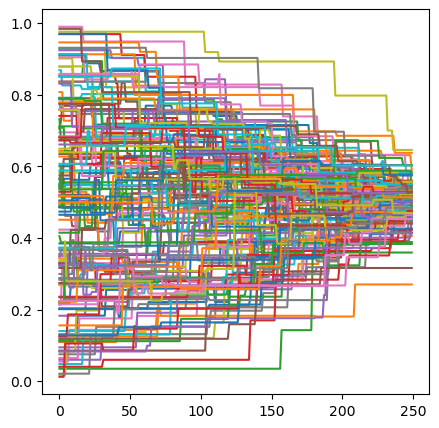

In [12]:
print_opinion_trajectory(X)

In [13]:
BoundedConfidenceBackfireSimulator = simulator_opinion_dynamics(create_edges_BC_backfire, opinion_update_BC_backfire, 
                                                                bernoulli_evidence, num_parameters = 5)


In [14]:
N1, T1, edge_per_t1, evidences_per_t1 = 150, 250, 8, 10
epsilon1, epsilon2, mu1, mu2, rho1 = 0.2, 0.8, 0.3, 0.3, 70

In [15]:
BoundedConfidenceBackfireSimulator.intialize_simulator(N1, T1, edge_per_t1, evidences_per_t1, entries_edges = 4)

In [16]:
X, edges, evidences = BoundedConfidenceBackfireSimulator.simulate_trajectory([epsilon1, epsilon2, mu1, mu2, rho1])

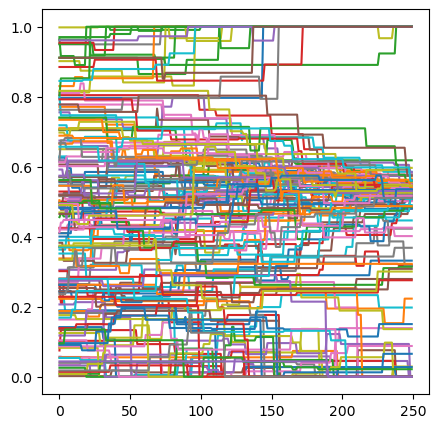

In [17]:
print_opinion_trajectory(X)

In [267]:
"""def create_edges_bauman(N, edge_per_t, diff_X, parameters):
    beta, K, alpha, dt = parameters
    
    u, v = torch.randint(low = 0, high = N, size = [2, edge_per_t], dtype = torch.long)
    s = (torch.rand(edge_per_t) < torch.abs(diff_X[u,v])**(-beta)).to(torch.long)
    
    
    return torch.cat([u[:,None], v[:,None], s[:,None]], dim = 1)
        

def opinion_update_bauman(diff_X, X_t, edges_t, N, parameters, adj_matrix):
    beta, K, alpha, dt = parameters
    
    updates = dt * (-X + K * torch.sum(adj_matrix @ torch.tanh(alpha * X)))
    
    X_t += updates
    X_t = np.clip(X_t, 1e-5, 1-1e-5)
    
    diff_X = X_t[:,None] - X_t[None,:]
    
    return X_t, diff_X"""

In [270]:
"""BaumannSimulator = simulator_opinion_dynamics(create_edges_bauman, opinion_update_bauman, 
                                              bernoulli_evidence, num_parameters = 4, with_adj_matrix = True)
"""